In [1]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import cobra
from cobra.io import read_sbml_model, write_sbml_model
%matplotlib inline

In [2]:
model = read_sbml_model('data/iYO844_modified.xml')

In [3]:
# Defining function to add dynamic bounds for glucose and biomass
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, DHAA = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
 
# Defining function to calculate the time derivative of external species
def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose, DHAA = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_BS_10', 'EX_glc__D_e','ALDH1_CYP71AV1'], ['max', 'max', 'max'])
 
    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass
 
    # This implementation is *not* efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None
 
# Defining event function to check feasibility
def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
    

    return feasibility - infeasible_event.epsilon

 
infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [4]:
# Performing the simulation
# Time span and initial conditions
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10, 0.01]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )


0it [00:00, ?it/s]

t = 5.999: : 196it [14:07,  4.32s/it]


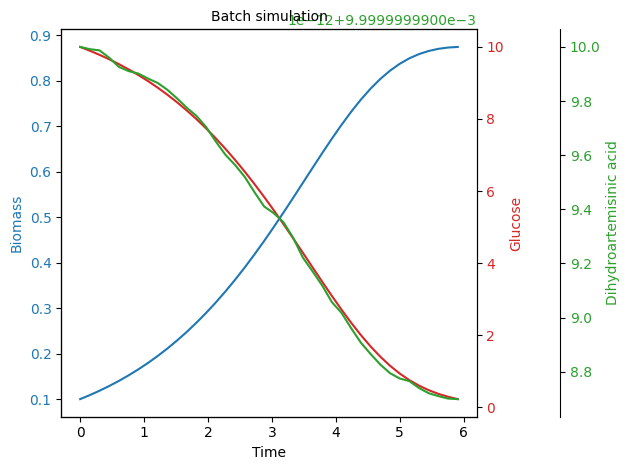

In [5]:
# Plot the results
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Biomass', color=color)
ax1.plot(sol.t, sol.y[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
 
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Glucose', color=color)
ax2.plot(sol.t, sol.y[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
 
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # adjust position of the third axis
ax3.set_ylabel('Dihydroartemisinic acid', color=color)
ax3.plot(sol.t, sol.y[2], color=color)
ax3.tick_params(axis='y', labelcolor=color)
 
plt.title('Batch simulation',fontsize=10)
fig.tight_layout()
plt.show()

In [6]:
sol.y[2]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])